In [1]:
import platform
import os
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [2]:
import pandas as pd
import numpy as np
import torch
import pickle
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob

In [3]:
# Load in metadata
meta = pd.read_json(f"{DATA_PATH}/Zalando_Germany_Dataset/dresses/metadata/dresses_metadata.json").T.rename_axis('sku').reset_index()
# Rename category "Cocktail dress / Party dress" to "Cocktail dress" to avoid problems in path definitions
meta['category'] = meta['category'].replace('Cocktail dress / Party dress', 'Cocktail dress')
# Rename "3/4 length" to "34 length" to avoid problems in path definitions
meta['sleeve_length'] = meta['sleeve_length'].replace('3/4 length', '34 length')

### Helper Functions

In [4]:
def tensor2im(var):
    var = var.cpu().detach().transpose(0, 2).transpose(0, 1).numpy()
    var = ((var + 1) / 2)
    var[var < 0] = 0
    var[var > 1] = 1
    var = var * 255
    return Image.fromarray(var.astype('uint8'))

In [5]:
def setup_generator():
    os.chdir(f"{ROOT_PATH}/stylegan2-ada-pytorch")
    # Load model architecture
    experiment_path = f"{DATA_PATH}/Models/Stylegan2_Ada/Experiments/00005-stylegan2_ada_images-mirror-auto2-kimg5000-resumeffhq512/"
    model_name = "network-snapshot-001200.pkl"
    model_path = experiment_path + model_name
    with open(model_path, 'rb') as f:
        architecture = pickle.load(f)
        G = architecture['G_ema']
        D = architecture['D']
    os.chdir(current_wd)
    return G

G = setup_generator()

In [6]:
def generate_from_latent(latent):
    img = G.synthesis(latent, force_fp32=True, noise_mode = 'const')
    img = tensor2im(img.squeeze(0))
    return img

In [7]:
def generate_pti(latent, G_PTI):
    gen = G_PTI.synthesis(latent, noise_mode='const', force_fp32=True)
    img = tensor2im(gen.squeeze(0))
    return img

In [8]:
def get_interpolations_multiple(latent_code, start_distance, end_distance, steps, dims_to_change, boundaries_base_dir):
    linspace = np.linspace(start_distance, end_distance, steps)

    # Repeat Latent for num_steps
    latent_code = latent_code.repeat(steps, 1, 1)


    for dim in dims_to_change:
        boundary = np.load(f"{boundaries_base_dir}boundary_dim{dim}.npy")
        boundary = torch.tensor(boundary)
        for i in range(steps):
            latent_code[i, dim, :] = latent_code[i, dim, :] + linspace[i] * boundary
    
    return latent_code

In [9]:
# def get_interpolations_multiple_projected(latent_code, start_distance, end_distance, steps, dims_to_change, boundaries_base_dir):
#     # Repeat Latent for num_steps
#     latent_code = latent_code.repeat(steps, 1, 1)


#     for dim in dims_to_change:
#         linspace = np.linspace(start_distance, end_distance, steps)
#         linspace = torch.tensor(linspace, dtype=torch.float32)
#         boundary = np.load(f"{boundaries_base_dir}boundary_dim{dim}.npy")
#         boundary = torch.tensor(boundary)

#         projection = latent_code[0, dim, :].reshape(1,-1).matmul(boundary.T)
#         linspace = linspace - np.array(projection)
#         for i in range(steps):
#             latent_code[i, dim, :] = latent_code[i, dim, :] + linspace[0, i] * boundary
    
#     return latent_code

### Interpolations with projection

In [10]:
# Define target attribute
attribute = 'category'
att1 = 'Day dress'
att2 = 'Occasion wear'

In [11]:
def run_example(attribute, att1, att2, steps=5, distance=15, dims_to_change=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]):

    try:
        input_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Inputs/e4e_00005/{attribute}/{att1}_{att2}/"
        boundaries_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Outputs/e4e_00005/{attribute}/{att1}_{att2}/"

        # Load in Metadata
        df = pd.read_csv(f"{input_base_dir}metadata.csv")
    except:
        att1, att2 = att2, att1
        input_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Inputs/e4e_00005/{attribute}/{att1}_{att2}/"
        boundaries_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Outputs/e4e_00005/{attribute}/{att1}_{att2}/"

        # Load in Metadata
        df = pd.read_csv(f"{input_base_dir}metadata.csv")

    # Load in original Latents
    latents = torch.load(f"{DATA_PATH}/Models/e4e/00005_snapshot_1200/inversions/latents_dict.pt")

    # Sample one latent
    sample = df.sample(1)
    latent_code = latents[sample.sku.item()]

    # Generate Interpolations
    if sample.label.item() == 0: 
        start_distance, end_distance = 0, distance
    elif sample.label.item() == 1: 
        start_distance, end_distance = -distance,  0

    interpolations = get_interpolations_multiple(latent_code, start_distance, end_distance, steps, dims_to_change, boundaries_base_dir)

    imgs = [generate_from_latent(interpolations[i, :, :].unsqueeze(0)) for i in range(steps)]
    fig, ax = plt.subplots(1, steps, figsize=(20, 5))
    ax = ax.ravel()
    for i in range(steps):
        ax[i].imshow(imgs[i])
        ax[i].axis('off')
        ax[i].set_title(f"{np.linspace(start_distance, end_distance, steps)[i]}")

    fig.suptitle(f"SKU: {sample.sku.item()}\nClass:{sample[attribute].item()} \n{att1} <-> {att2}")
    plt.show()

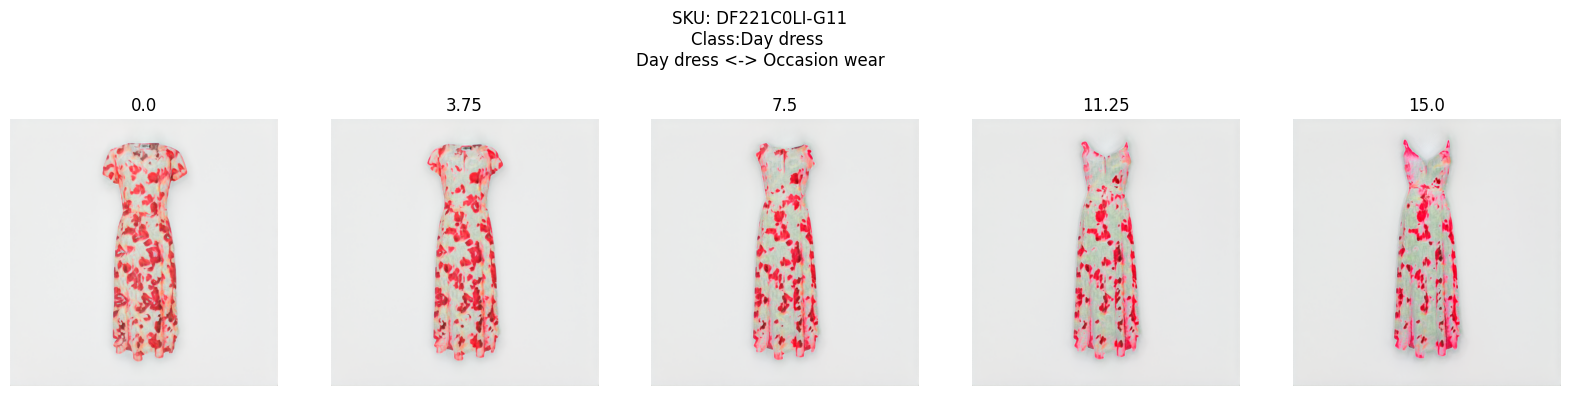

In [12]:
attribute = 'category'
att1 = 'Occasion wear'
att2 = 'Day dress'

run_example(attribute, att1, att2)

### Test Directions with PTI Generator

In [13]:
os.chdir(f"{ROOT_PATH}/2_Inversion/PTI/")
from pti_utils import load_pti
os.chdir(current_wd)

def run_pti_example(sku, att1, att2):
    steps = 5
    start_distance = -10
    end_distance = 10
    dims_to_change = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


    device = torch.device('cpu')
    
    G_PTI, latent = load_pti(sku)

    # Freeze and set to eval
    G_PTI.eval()
    for param in G_PTI.parameters():
        param.requires_grad = False

    # Send to CPU
    G_PTI = G_PTI.to(device)
    latent_pti = latent.to(device)

    boundaries_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Outputs/e4e_00005/{attribute}/{att1}_{att2}/"

    interpolations = get_interpolations_multiple(latent_pti, start_distance, end_distance, steps, dims_to_change, boundaries_base_dir)

    imgs = [generate_pti(interpolations[i, :, :].unsqueeze(0), G_PTI) for i in range(steps)]
    fig, ax = plt.subplots(1, steps, figsize=(20, 5))
    ax = ax.ravel()
    for i in range(steps):
        ax[i].imshow(imgs[i])
        ax[i].axis('off')
        ax[i].set_title(f"{np.linspace(start_distance, end_distance, steps)[i]}")
    fig.suptitle(f"{att1} <-> {att2}")

    plt.show()

Using cpu as device


/pfs/work7/workspace/scratch/tu_zxmav84-thesis/miniconda3/envs/thesis/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


STH21C0OH-Q11


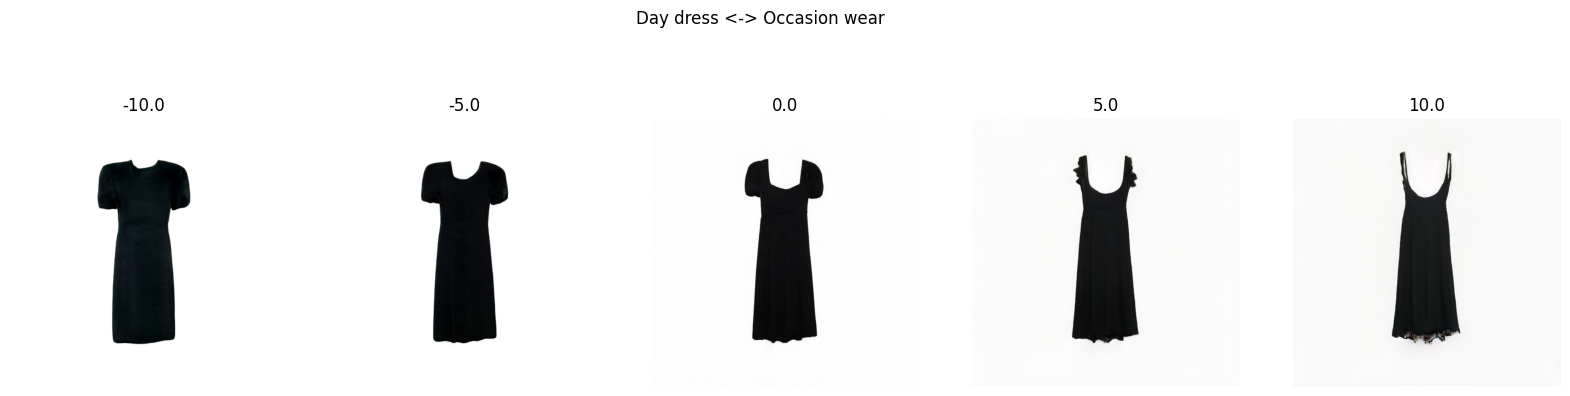

EV421C10R-Q11


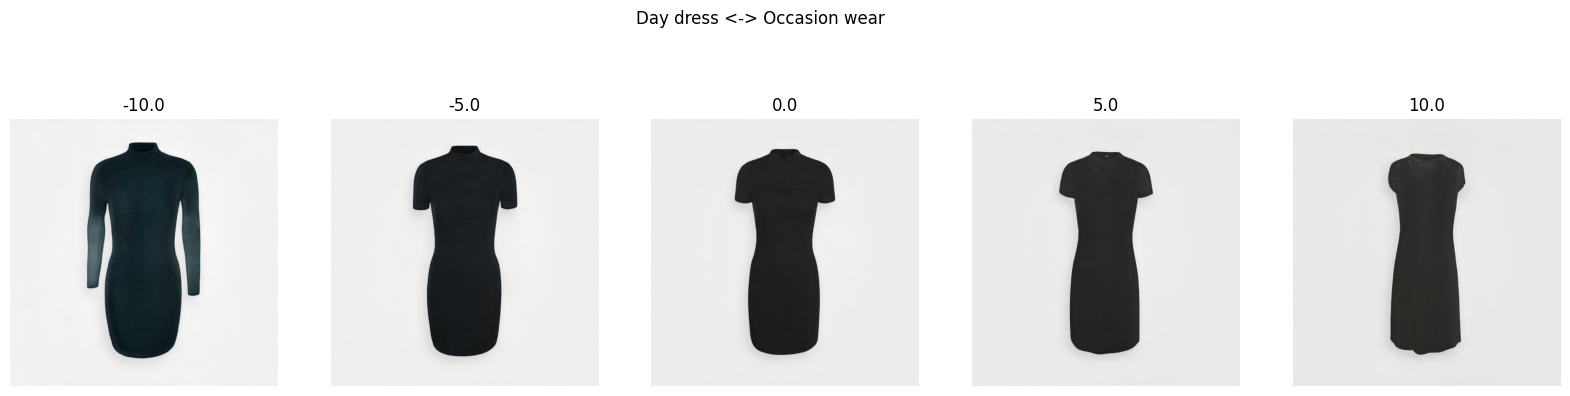

NX321C44T-E11


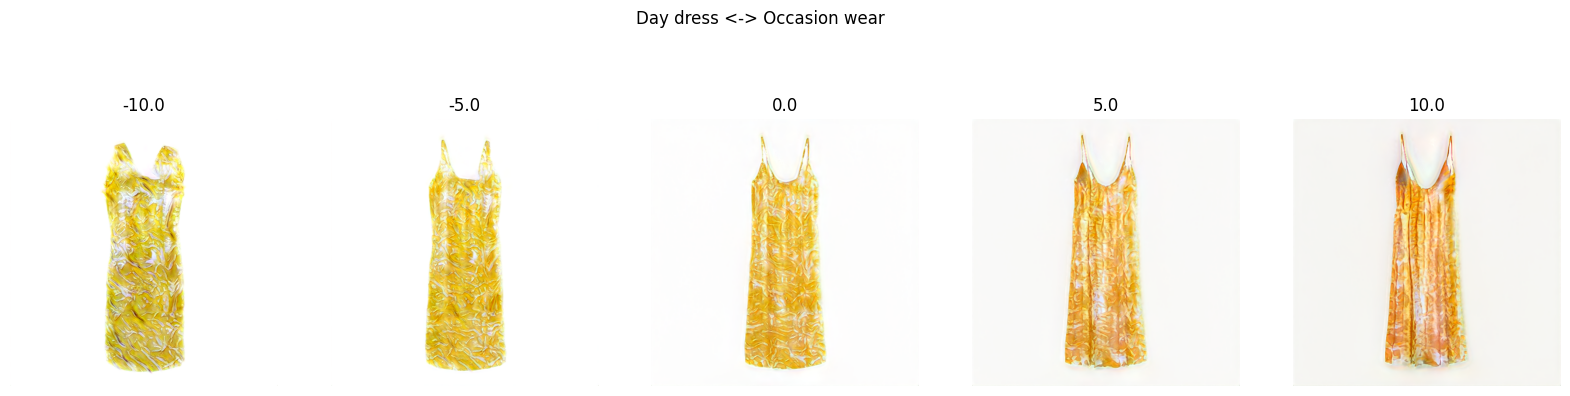

YOD21C0T1-M11


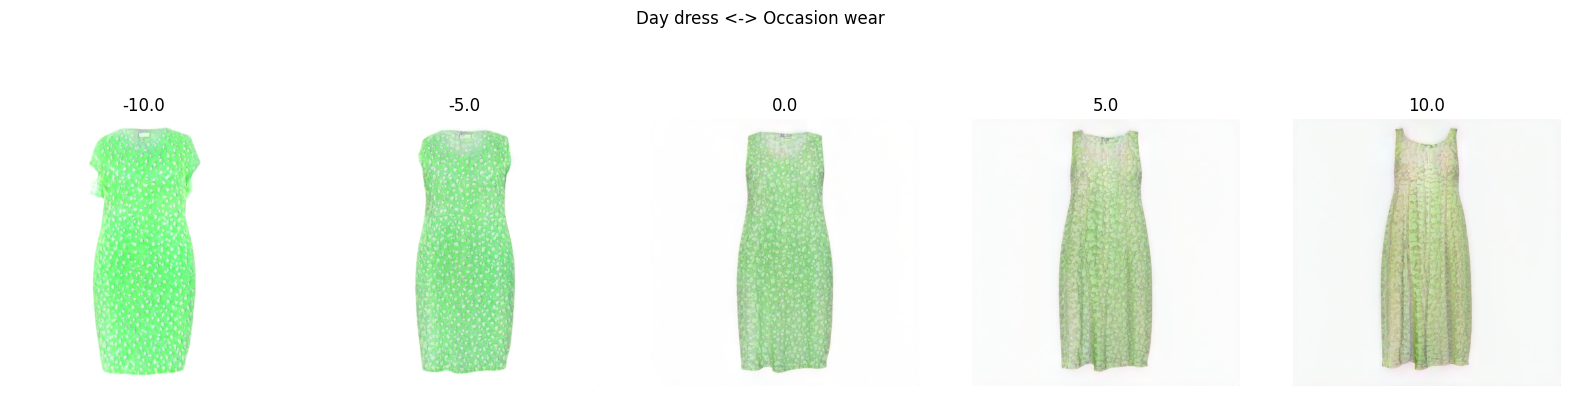

NN121C0GV-K11


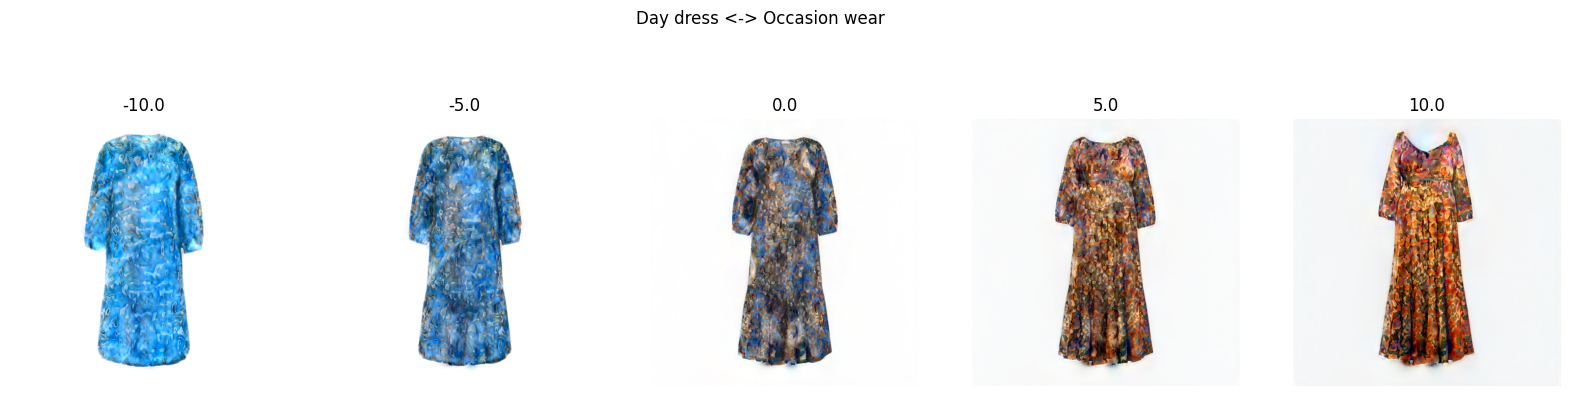

In [14]:
attribute = 'category'
att1 = 'Day dress'
att2 = 'Occasion wear'

for i in range(5):
    if platform.system() == 'Linux':
        skus = list(glob('/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/PTI/experiments/embeddings/zalando_germany/PTI/*'))
        skus = [elem.split('/')[-1] for elem in skus]
        sub = meta[meta.sku.isin(skus) & (meta.category == att1)]
        sku = sub.sample(1).sku.item()
    elif platform.system() == 'Darwin':
        sku = 'SOA21C0KG-J11'
        #sku = "02R21C014-Q11"
    run_pti_example(sku, att1, att2)

    if platform.system() == 'Darwin':
        break

### Disentanglement Analysis: Sequentially Applied Manipulations

In [15]:
# Load in metadata
meta = pd.read_json(f"{DATA_PATH}/Zalando_Germany_Dataset/dresses/metadata/dresses_metadata.json").T.rename_axis('sku').reset_index()
meta['sleeve_length'] = meta['sleeve_length'].replace('3/4 length', '34 length')

# Load in latents
latents = torch.load(f"{DATA_PATH}/Models/e4e/00005_snapshot_1200/inversions/latents_dict.pt")

In [16]:
def sequential_manipualtion(orig_category, orig_sleeve, orig_color, target_category, target_sleeve, target_color, dims_to_change, manipulation_strength):

    # Find item with original attributes
    subset = meta[(meta.category == orig_category) & (meta.sleeve_length == orig_sleeve) & (meta.color == orig_color)]
    if len(subset) == 0:
        print("No items found for this combination")
    else:
        sample = subset.sample(1)


    # Get correct boundaries paths: 
    try: 
        boundaries_base_dir_category = f"{DATA_PATH}/Models/InterfaceGAN/Outputs/e4e_00005/category/{orig_category}_{target_category}/"
        boundary_category = np.load(f"{boundaries_base_dir_category}boundary_dim0.npy")
        category_target_direction = 'pos'
    except: 
        boundaries_base_dir_category = f"{DATA_PATH}/Models/InterfaceGAN/Outputs/e4e_00005/category/{target_category}_{orig_category}/"
        category_target_direction = 'neg'

    try:
        boundaries_base_dir_sleeve_length = f"{DATA_PATH}/Models/InterfaceGAN/Outputs/e4e_00005/sleeve_length/{orig_sleeve}_{target_sleeve}/"
        boundary_sleeve = np.load(f"{boundaries_base_dir_sleeve_length}boundary_dim0.npy")
        sleeve_length_target_direction = 'pos'
    except:
        boundaries_base_dir_sleeve_length = f"{DATA_PATH}/Models/InterfaceGAN/Outputs/e4e_00005/sleeve_length/{target_sleeve}_{orig_sleeve}/"
        sleeve_length_target_direction = 'neg'

    try:
        boundaries_base_dir_color = f"{DATA_PATH}/Models/InterfaceGAN/Outputs/e4e_00005/color/{orig_color}_{target_color}/"
        boundary_color = np.load(f"{boundaries_base_dir_color}boundary_dim0.npy")
        color_target_direction = 'pos'
    except:
        boundaries_base_dir_color = f"{DATA_PATH}/Models/InterfaceGAN/Outputs/e4e_00005/color/{target_color}_{orig_color}/"
        color_target_direction = 'neg'

    print("Generating Original Image")
    orig_latent = latents[sample.sku.item()]
    img_orig = generate_from_latent(orig_latent)

    # Make category manipulation
    print("Generating Category Manipulation")
    if category_target_direction == 'pos':
        start_distance, end_distance = manipulation_strength[0], manipulation_strength[0]
    elif category_target_direction == 'neg':
        start_distance, end_distance = -manipulation_strength[0], -manipulation_strength[0]
    interpolations_category = get_interpolations_multiple(orig_latent, start_distance, end_distance, 1, dims_to_change, boundaries_base_dir_category)
    img_category = generate_from_latent(interpolations_category)

    # Make sleeve manipulation
    print("Generating Sleeve Length Manipulation")
    if sleeve_length_target_direction == 'pos':
        start_distance, end_distance = manipulation_strength[1], manipulation_strength[1]
    elif sleeve_length_target_direction == 'neg':
        start_distance, end_distance = -manipulation_strength[1], -manipulation_strength[1]
    interpolations_sleeve = get_interpolations_multiple(interpolations_category, start_distance, end_distance, 1, dims_to_change, boundaries_base_dir_sleeve_length)
    img_sleeve = generate_from_latent(interpolations_sleeve)

    # Color manipulation
    print("Generating Color Manipulation")
    if color_target_direction == 'pos':
        start_distance, end_distance = manipulation_strength[2], manipulation_strength[2]
    elif color_target_direction == 'neg':
        start_distance, end_distance = -manipulation_strength[2], -manipulation_strength[2]

    interpolations_color = get_interpolations_multiple(interpolations_sleeve, start_distance, end_distance, 1, dims_to_change, boundaries_base_dir_color)
    img_color = generate_from_latent(interpolations_color)


    # Plot Everything
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    ax = ax.ravel()
    ax[0].imshow(img_orig)
    ax[0].axis('off')
    ax[0].set_title("Original")

    ax[1].imshow(img_category)
    ax[1].axis('off')
    ax[1].set_title(f"+ {target_category}")

    ax[2].imshow(img_sleeve)
    ax[2].axis('off')
    ax[2].set_title(f"+ {target_sleeve}")

    ax[3].imshow(img_color)
    ax[3].axis('off')
    ax[3].set_title(f"+ {target_color}")

    plt.show()

Generating Original Image
Generating Category Manipulation
Generating Sleeve Length Manipulation
Generating Color Manipulation


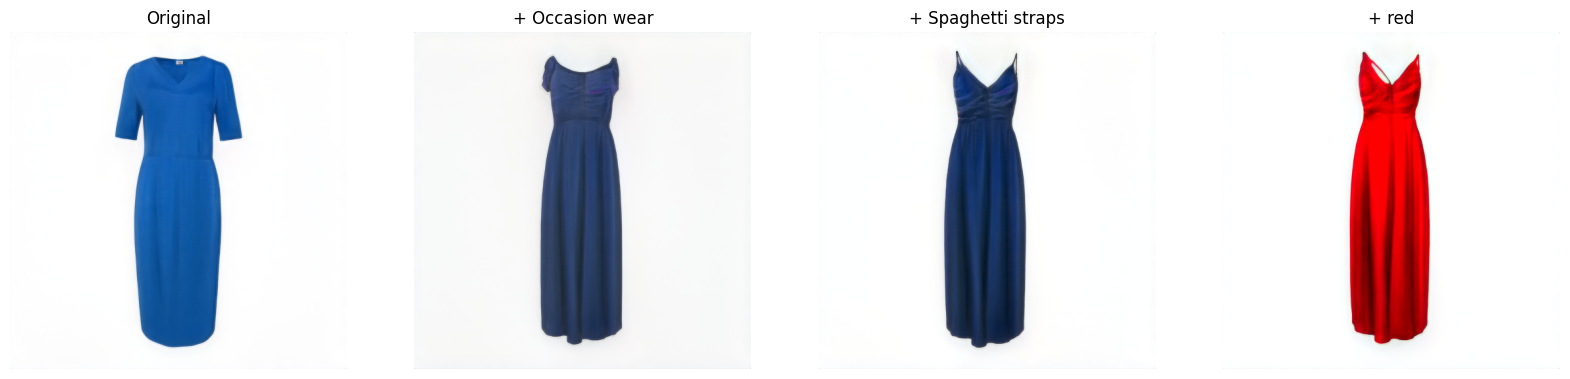

In [17]:
orig_category = 'Day dress'
orig_sleeve = 'Short'
orig_color = 'blue'

target_category = 'Occasion wear'
target_sleeve = 'Spaghetti straps'
target_color = 'red'

dims_to_change = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
manipulation_strengths = [15, 10, 10]

sequential_manipualtion(orig_category, orig_sleeve, orig_color, target_category, target_sleeve, target_color, dims_to_change, manipulation_strengths)

### Test Conditionally Disentangled Directons

In [18]:
def project_boundary(primal, *args):
  """Projects the primal boundary onto condition boundaries.
  
  The function is used for conditional manipulation, where the projected vector
  will be subscribed from the normal direction of the original boundary. Here,
  all input boundaries are supposed to have already been normalized to unit
  norm, and with same shape [1, latent_space_dim].
  
  Args:
    primal: The primal boundary.
    *args: Other boundaries as conditions.
  
  Returns:
    A projected boundary (also normalized to unit norm), which is orthogonal to
      all condition boundaries.
  
  Raises:
    LinAlgError: If there are more than two condition boundaries and the method fails 
                 to find a projected boundary orthogonal to all condition boundaries.
  """
  assert len(primal.shape) == 2 and primal.shape[0] == 1

  if not args:
    return primal
  if len(args) == 1:
    cond = args[0]
    assert (len(cond.shape) == 2 and cond.shape[0] == 1 and
            cond.shape[1] == primal.shape[1])
    new = primal - primal.dot(cond.T) * cond
    return new / np.linalg.norm(new)
  elif len(args) == 2:
    cond_1 = args[0]
    cond_2 = args[1]
    assert (len(cond_1.shape) == 2 and cond_1.shape[0] == 1 and
            cond_1.shape[1] == primal.shape[1])
    assert (len(cond_2.shape) == 2 and cond_2.shape[0] == 1 and
            cond_2.shape[1] == primal.shape[1])
    primal_cond_1 = primal.dot(cond_1.T)
    primal_cond_2 = primal.dot(cond_2.T)
    cond_1_cond_2 = cond_1.dot(cond_2.T)
    alpha = (primal_cond_1 - primal_cond_2 * cond_1_cond_2) / (
        1 - cond_1_cond_2 ** 2 + 1e-8)
    beta = (primal_cond_2 - primal_cond_1 * cond_1_cond_2) / (
        1 - cond_1_cond_2 ** 2 + 1e-8)
    new = primal - alpha * cond_1 - beta * cond_2
    return new / np.linalg.norm(new)
  else:
    for cond_boundary in args:
      assert (len(cond_boundary.shape) == 2 and cond_boundary.shape[0] == 1 and
              cond_boundary.shape[1] == primal.shape[1])
    cond_boundaries = np.squeeze(np.asarray(args))
    A = np.matmul(cond_boundaries, cond_boundaries.T)
    B = np.matmul(cond_boundaries, primal.T)
    x = np.linalg.solve(A, B)
    new = primal - (np.matmul(x.T, cond_boundaries))
    return new / np.linalg.norm(new)


In [19]:
def get_interpolations_conditional(latent_code, start_distance, end_distance, steps, dims_to_change, boundaries_base_dir, condition_base_dir):
    linspace = np.linspace(start_distance, end_distance, steps)

    # Repeat Latent for num_steps
    latent_code = latent_code.repeat(steps, 1, 1)


    for dim in dims_to_change:
        boundary = np.load(f"{boundaries_base_dir}boundary_dim{dim}.npy")
        condition = np.load(f"{condition_base_dir}boundary_dim{dim}.npy")

        projected_boundary = project_boundary(boundary, condition)

        assert not np.all(boundary == projected_boundary)

        projected_boundary = torch.tensor(projected_boundary)
        for i in range(steps):
            latent_code[i, dim, :] = latent_code[i, dim, :] + linspace[i] * projected_boundary
    
    return latent_code

In [20]:
def run_example_conditional(attribute, att1, att2, condition_att, steps=5, distance=15, dims_to_change=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]):
    try:
        input_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Inputs/e4e_00005/{attribute}/{att1}_{att2}/"
        boundaries_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Outputs/e4e_00005/{attribute}/{att1}_{att2}/"
        np.load(f"{boundaries_base_dir}boundary_dim0.npy")

    except:
        att1, att2 = att2, att1
        input_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Inputs/e4e_00005/{attribute}/{att1}_{att2}/"
        boundaries_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Outputs/e4e_00005/{attribute}/{att1}_{att2}/"

    # Load in original Latents
    latents = torch.load(f"{DATA_PATH}/Models/e4e/00005_snapshot_1200/inversions/latents_dict.pt")

    # Sample one latent
    subset = meta[meta[attribute] == att1]
    sample = subset.sample(1)
    latent_code = latents[sample.sku.item()]

    # Find best conditional boundary as boundary which was trained on the most data points
    summary_stats = pd.read_csv(f'{DATA_PATH}/Models/InterfaceGAN/Inputs/e4e_00005/{condition_att}/summary_stats.csv')
    best_conditional_boundary = summary_stats[(summary_stats['Unnamed: 0'] == sample[condition_att].item()) | (summary_stats['Unnamed: 1'] == sample[condition_att].item())].sort_values('num_samples', ascending=False).iloc[0]

    condition_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Outputs/e4e_00005/{condition_att}/{best_conditional_boundary['Unnamed: 0']}_{best_conditional_boundary['Unnamed: 1']}/"

    # Generate Interpolations
    if sample[attribute].item() == att1: 
        start_distance, end_distance = 0, distance
    elif sample[attribute].item() == att2:
        start_distance, end_distance = -distance,  0


    interpolations = get_interpolations_multiple(latent_code, start_distance, end_distance, steps, dims_to_change, boundaries_base_dir)

    imgs = [generate_from_latent(interpolations[i, :, :].unsqueeze(0)) for i in range(steps)]
    fig, ax = plt.subplots(1, steps, figsize=(20, 5))
    ax = ax.ravel()
    for i in range(steps):
        ax[i].imshow(imgs[i])
        ax[i].axis('off')
        ax[i].set_title(f"{np.linspace(start_distance, end_distance, steps)[i]}")

    fig.suptitle(f"SKU: {sample.sku.item()}\nClass:{sample[attribute].item()} \n{att1} <-> {att2}\nCondition: {condition_att} (used boundary: {best_conditional_boundary['Unnamed: 0']} <-> {best_conditional_boundary['Unnamed: 1']})")
    plt.show()

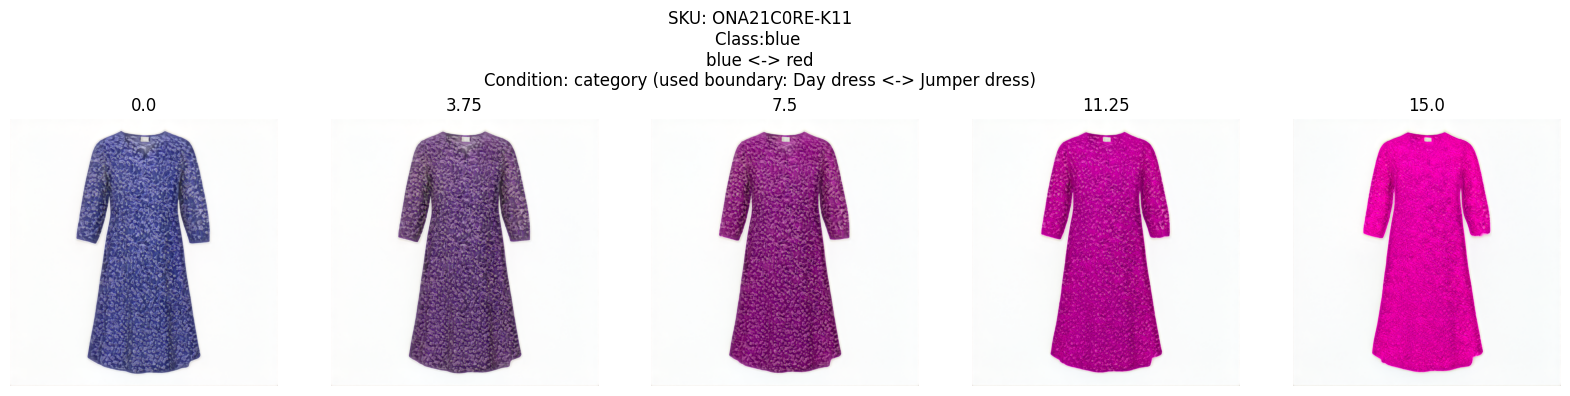

In [21]:
attribute = 'color'
att1 = 'red'
att2 = 'blue'
condition_att = 'category'


run_example_conditional(attribute, att1, att2, condition_att)

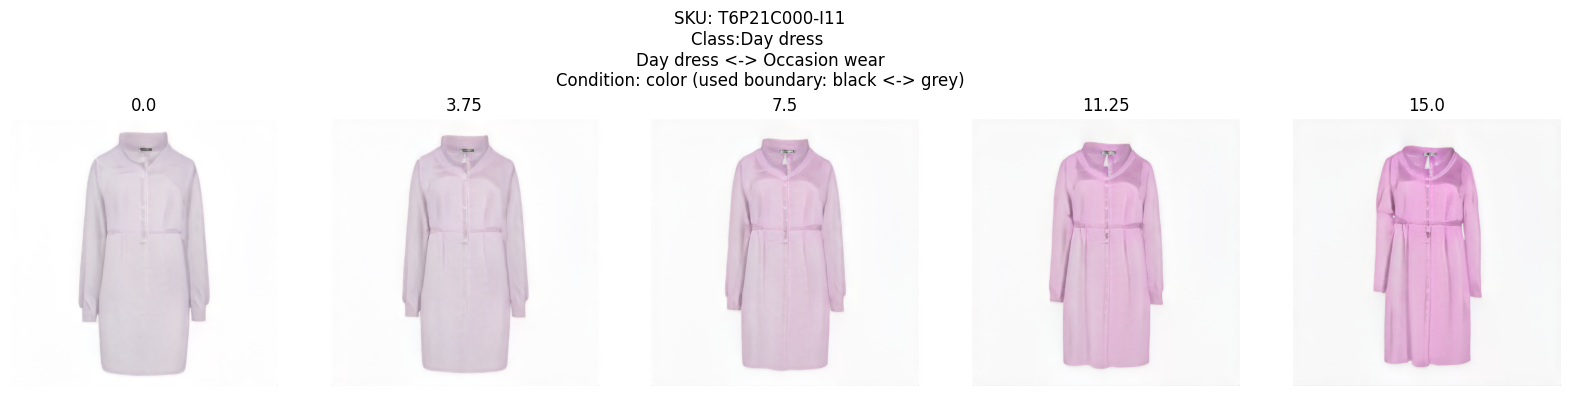

In [25]:
attribute = 'category'
att1 = 'Day dress'
att2 = 'Occasion wear'
condition_att = 'color'

run_example_conditional(attribute, att1, att2, condition_att)